In [1]:
import torch

In [7]:
!python --version

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Python 3.7.10


In [5]:
torch.__version__, torch.version.cuda , 

('1.7.1', '11.0')

In [ ]:
#!python -m pip install detectron2 -f \
 # https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html

In [9]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.7")   # please manually install torch 1.9 if Colab changes its default version

1.7.1 True


In [128]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import time
import datetime
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import copy
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import build_detection_train_loader
import logging

In [11]:
t = torch.zeros([1],device='cuda')

In [115]:
 from detectron2.data.datasets import register_coco_instances
    
def data_registration(train_dir,train_name,valid_dir,valid_name):
    path_train_coco = os.path.join(train_dir,"Train.json")
    path_train_imgs = os.path.join(train_dir, "Images")
    path_train_masks = os.path.join(train_dir, "Masks")
    
    path_valid_coco= os.path.join(valid_dir,"Valid.json")
    path_valid_imgs =  os.path.join(valid_dir, "Images")
    path_valid_masks = os.path.join(valid_dir, "Masks")

      
    print("Totoal Train Images in folder => ", len(os.listdir(path_train_imgs)))
    print("Totoal Train Mask in folder => ", len(os.listdir(path_train_masks)))
    print('\n')

    print("Totoal Valid Images  in folder =>", len(os.listdir(path_valid_imgs)))
    print("Totoal Valid Mask  in folder => ", len(os.listdir(path_valid_masks)))
    
    try:   
        register_coco_instances(train_name, {}, path_train_coco, path_train_imgs)
        register_coco_instances(valid_name, {}, path_valid_coco, path_valid_imgs)
    except AssertionError:
        print("\n Data set Already registered! Change string if want to re-register!")
    
    train_data=detectron2.data.datasets.load_coco_json(path_train_coco, path_train_imgs, dataset_name=train_name, extra_annotation_keys=None)
    valid_data=detectron2.data.datasets.load_coco_json(path_valid_coco, path_valid_imgs, dataset_name=valid_name, extra_annotation_keys=None)
 
    meta_train = MetadataCatalog.get(train_name).set(thing_classes=["Rail_road"])
    meta_valid = MetadataCatalog.get(valid_name).set(thing_classes=["Rail_road"])
    
    print("No of Train = ",len(train_data))
    print("No of Valid = ",len(valid_data))
    
    return train_data,meta_train, valid_data,meta_valid    



In [116]:
train_dir = "Data/Train"
valid_dir = "Data/Valid"
train_name = "Train"
valid_name = "Valid"

train_data,meta_train, valid_data,meta_valid     =  data_registration(train_dir,train_name,valid_dir,valid_name)
meta_valid

Totoal Train Images in folder =>  1397
Totoal Train Mask in folder =>  1397


Totoal Valid Images  in folder => 501
Totoal Valid Mask  in folder =>  501
[10/06 15:07:35 d2.data.datasets.coco]: Loaded 1397 images in COCO format from Data/Train/Train.json
[10/06 15:07:35 d2.data.datasets.coco]: Loaded 501 images in COCO format from Data/Valid/Valid.json
No of Train =  1397
No of Valid =  501


namespace(name='Valid',
          json_file='Data/Valid/Valid.json',
          image_root='Data/Valid/Images',
          evaluator_type='coco',
          thing_classes=['Rail_road'],
          thing_dataset_id_to_contiguous_id={1: 0})

In [123]:
# solve visualisation issue, remove list appending 
%matplotlib inline
from detectron2.data import DatasetCatalog
from PIL import Image

def visualize_data(dataset_name,no_of_display_imgs_):
    
    dataset_dicts = DatasetCatalog.get(dataset_name)
    
    for d in random.sample(dataset_dicts, no_of_display_imgs_):
        img = cv2.imread(d['file_name'])
        print(d['file_name'])
        visualizer = Visualizer(img[:, :, ::-1], metadata=meta_train, scale=0.5)
        out = visualizer.draw_dataset_dict(d)
        img = Image.fromarray(out.get_image()[:, :, ::-1], 'RGB')
        img.show()

In [ ]:
visualize_data(train_name,2)

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = (train_name,)
cfg.DATASETS.TEST = (valid_name,)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 4


cfg.SOLVER.LR_SCHEDULER_NAME =  "WarmupCosineLR"
cfg.SOLVER.gamma = 0.1
# cfg.SOLVER.momentum = 1.0
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2400    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = [0,600,1800]        # do not decay learning rate



cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 2   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1    # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

cfg.TEST.EVAL_PERIOD = 400

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)

trainer.resume_or_load(resume=False)
# trainer.train()

In [127]:
# Look at training curves in tensorboard:
#
import os
import json
import pandas as pd
import matplotlib.pyplot as plt


"""Saveing all plots in /plots directory 
NOTE: All The plots are between repective attribute and iteration
For Graphical results open Plots directory
"""

def plots(logs_dir):
    path = os.path.join(logs_dir,'metrics.json')
    df = pd.read_json(path,lines=True)
    iteration = df['iteration']
    for i in df.keys():
        plt.figure()
        plt.title(i)
        plt.plot(iteration,list(df[i]))
        plt.savefig(os.path.join(logs_dir,'plots', i.split('/')[0]+'.png'))
    
    
    
# (plots('output'))    
    
    
    

In [118]:
# Inference

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)


[10/06 15:10:26 d2.data.datasets.coco]: Loaded 501 images in COCO format from Data/Valid/Valid.json


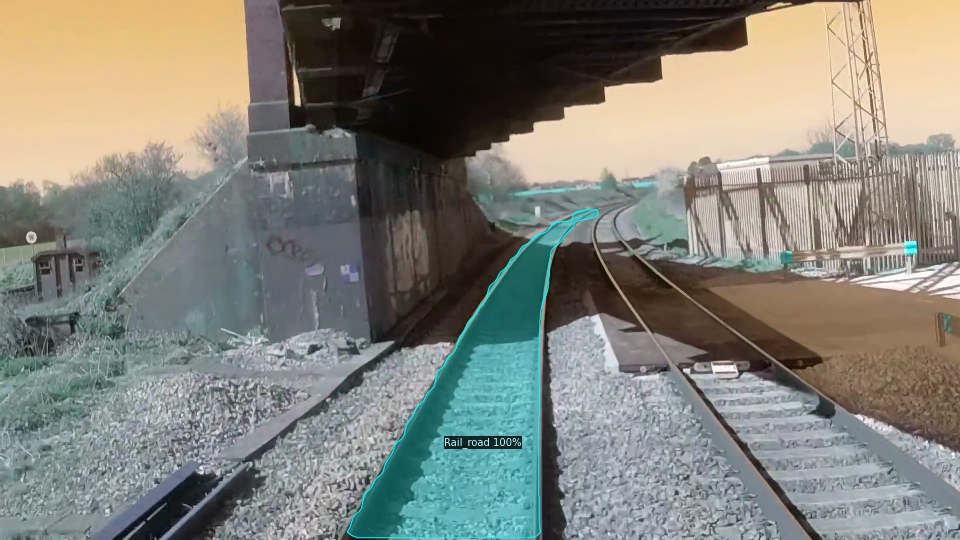

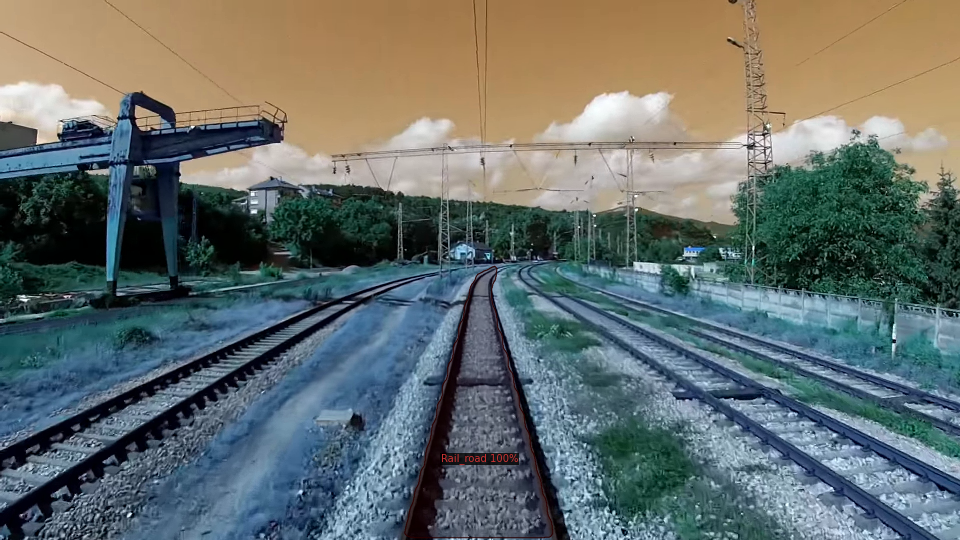

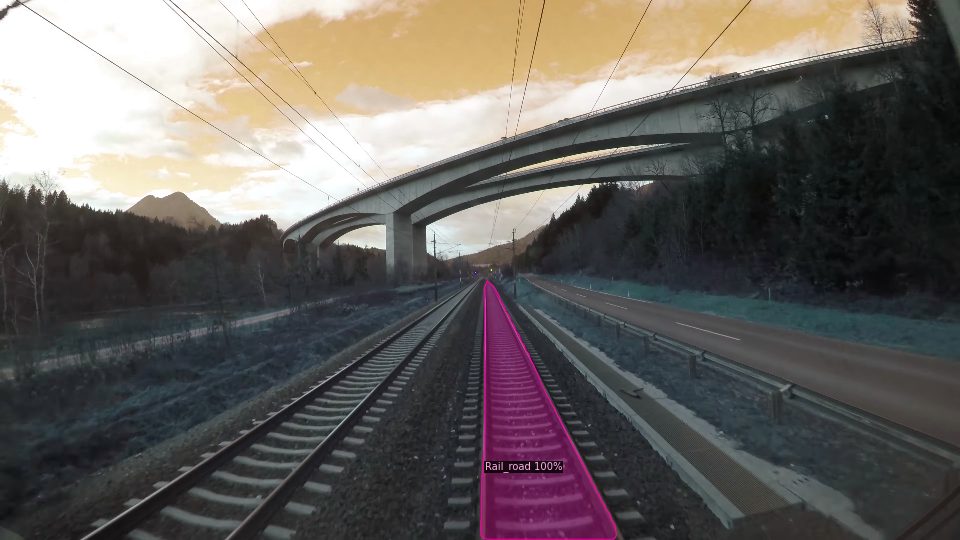

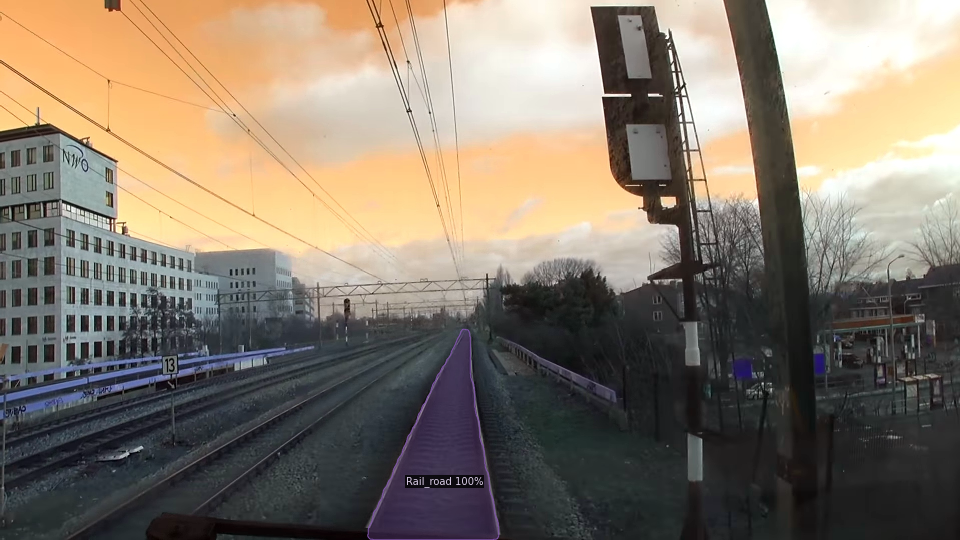

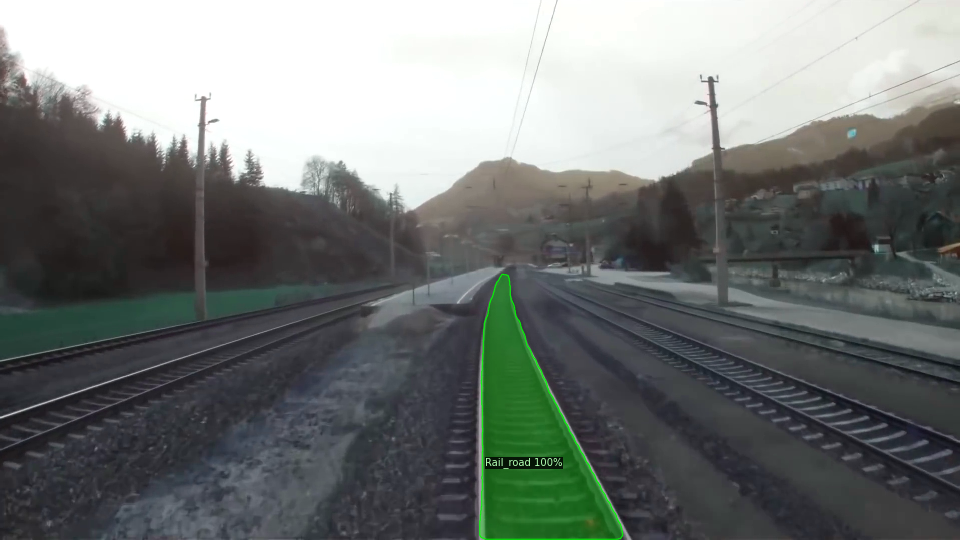

In [124]:
from detectron2.utils.visualizer import ColorMode ,GenericMask
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get(valid_name)
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    del outputs['instances'].get_fields()['pred_boxes']
    v = Visualizer(im[:, :, ::-1],
                   metadata=meta_train, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    img = Image.fromarray(out.get_image()[:, :, ::-1], 'RGB')
    img.show()   


In [126]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(valid_name, output_dir="./output")
val_loader = build_detection_test_loader(cfg, valid_name)
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[10/06 15:11:16 d2.data.datasets.coco]: Loaded 501 images in COCO format from Data/Valid/Valid.json
[10/06 15:11:16 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| Rail_road  | 500          |
|            |              |
[10/06 15:11:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/06 15:11:16 d2.data.common]: Serializing 501 elements to byte tensors and concatenating them all ...
[10/06 15:11:16 d2.data.common]: Serialized dataset takes 0.25 MiB
[10/06 15:11:16 d2.evaluation.evaluator]: Start inference on 501 batches
[10/06 15:11:17 d2.evaluation.evaluator]: Inference done 11/501. Dataloading: 0.0007 s/iter. Inference: 0.1069 s/iter. Eval: 0.0064 s/iter. Total: 0.1140 s/iter. ETA=0:00:55
[10/06 15:11:23 d2.evaluation.evaluator]: Inference done 55/501. Dataloading: 0.0010 s/iter. Inferen

In [145]:
''' 
Calculating time for inference on single image

'''
import time
im = cv2.imread("Data/Test_Real_Time/Images/rs00501.jpg")
time.time() 
outputs = predictor(im)
print("Model takes ",int(time.time()%60),"secounds for 1 image")

Model takes  33 secounds for 1 image


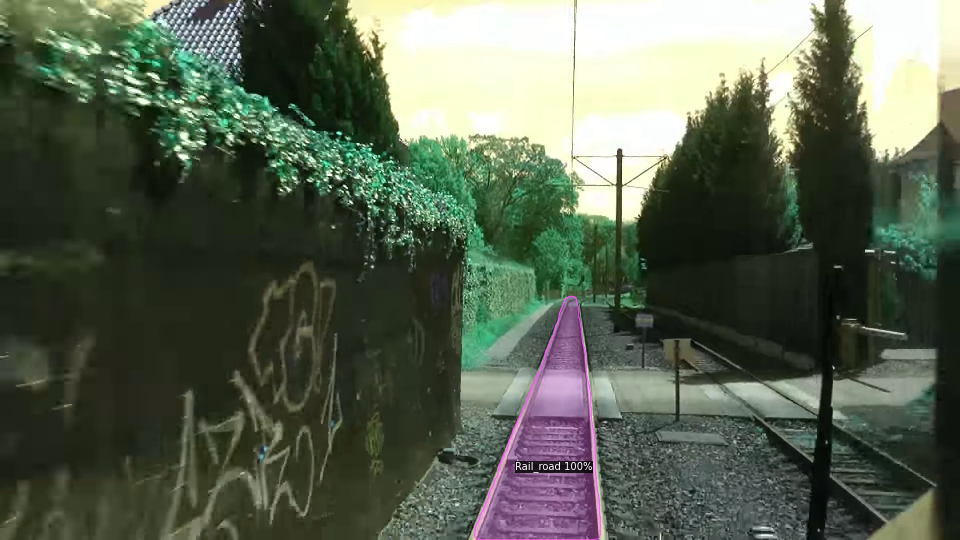

In [146]:
del outputs['instances'].get_fields()['pred_boxes']
v = Visualizer(im[:, :, ::-1],
               metadata=meta_train, 
               scale=0.5, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = Image.fromarray(out.get_image()[:, :, ::-1], 'RGB')
img.show()  

In [ ]:
import shutil

shutil.make_archive('~/Desktop/zipfile', 'zip', '~/Documents/', 'foldertozip')
